In [4]:
import pandas as pd
import numpy as np
from pathlib import Path
from labbench import stopwatch
import os

# plotting libraries
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.dates as mdates
import dateutil as dtu
import datetime as dt


# this is a development environment hack!
# after pip install of sea_ingest, you'd just import sea_ingest
import sea_ingest

sensname = "HU"
data_path = Path(r"data")
plt.style.use("ieee-publication-double-column.mplstyle")

## Functions used for processing and resampling colormaps

dbsum and dbmean are for the PSD resampling technique, performing the action in linear units before converting back into dB space

limiter - performs a check to limit the number of samples per frequency - this forces edge conditions where we may have not all frequency bins of data into compliance. Note the method here is not very clean and definitely needs improvement. 


In [5]:
def dbsum(x):
    y = np.sum(10 ** (x / 10))
    ydb = 10 * np.log10(y)
    return ydb


def dbmean(x):
    y = np.mean(10 ** (x / 10))
    ydb = 10 * np.log10(y)
    return ydb


def resampledf(psd):
    xx = psd.T
    idx = xx.index
    idx = pd.DataFrame(idx.groupby(np.arange(len(xx.index)) // 25)).mean()
    xx = xx.groupby(np.arange(len(xx.index)) // 25, axis=0).apply(dbmean)
    xx.index = idx.values
    return xx.T


def limiter(df, index_key="frequency"):
    df_g = df.reset_index(level="datetime").groupby(level=[index_key])
    lim = df_g.size().min()
    df_lim = df_g.nth[:lim]
    df_lim = df_lim.reset_index().set_index([index_key, "datetime"])
    return df_lim

## DF processing functions for image input

Converts the edge compute data dataframe into a dictionary used for matplotlib pccolormaps. 

day_psd = processes the Power Spectral Density ('max' capture statistic)
day_overload = extracts and processes overload flags from channelized_metadata
day_pfp = extracts and processes Periodic Frame Power for mean-rms and max-max pairing of the capture_statistic and detector


In [6]:
def day_psd(day_df):
    psd = resampledf(
        day_df["psd"]
    )  # resamples the PSD to a more meaningful number of values for plotting.
    df = (
        psd.xs("max", level="capture_statistic")
        .swaplevel("frequency", "datetime")
        .sort_index()
    )

    df_lim = limiter(
        df
    )  # limiter is a coarse method to adjust limitations due to un-equal number of per frequency captures during that day
    f0 = df_lim.index.get_level_values(
        "frequency"
    ).unique()  # core frequency components for the colormaps
    dfc = df_lim.xs(
        f0.min(), level="frequency"
    )  # sets the datetimestamp of the data to that of the lowest frequency
    timestamps = dfc.index
    basef = dfc.columns.astype(float)
    freqs = np.array(
        [np.array(basef) + c for c in np.array(f0)]
    ).flatten()  # combines the channel frequecny with the base frequency within the channel
    dfr = (
        df_lim.reset_index("datetime", drop=True)
        .unstack("frequency")
        .T.swaplevel()
        .sort_index()
    )

    X, Y = np.meshgrid(timestamps, freqs / 1e6)
    psd_image = {"time": X.T, "freq": Y.T, "psd": np.reshape(dfr.values, X.shape).T}
    return psd_image

In [7]:
def day_overload(day_df):
    ovr = pd.DataFrame(day_df["channel_metadata"]["overload"]).swaplevel().sort_index()
    ovr = ovr.overload.map({True: -1, False: 1})
    ovr_lim = limiter(ovr)
    f0 = ovr_lim.index.get_level_values("frequency").unique()
    ovr_c = ovr_lim.xs(f0.min(), level="frequency")
    timestamps = ovr_c.index

    X, Y = np.meshgrid(timestamps, f0 / 1e6)
    ovr_image = {"time": X.T, "freq": Y.T, "ovr": np.reshape(ovr_lim.values, X.shape).T}
    return ovr_image

In [8]:
def day_pfp(day_df):
    pfp_median = (
        day_df["pfp"]
        .xs(["mean", "rms"], level=["capture_statistic", "detector"], drop_level=True)
        .median(axis=1)
    )
    pfp_max = (
        day_df["pfp"]
        .xs(["max", "peak"], level=["capture_statistic", "detector"], drop_level=True)
        .max(axis=1)
    )
    pfp = pd.concat([pfp_median, pfp_max], axis=1)
    pfp.columns = ["median", "max"]
    pfp = pfp.swaplevel().sort_index()
    pfp_lim = limiter(pfp)

    f0 = pfp_lim.index.get_level_values("frequency").unique()
    pfp_c = pfp_lim.xs(f0.min(), level="frequency")
    timestamps = pfp_c.index

    X, Y = np.meshgrid(timestamps, f0 / 1e6)
    pfp_image = {
        "time": X.T,
        "freq": Y.T,
        "pfp_median": np.reshape(pfp_lim["median"].values, X.shape).T,
        "pfp_max": np.reshape(pfp_lim["max"].values, X.shape).T,
    }
    return pfp_image

## Plotting function for the Edge Compute Payloads. 

In [9]:
def detector_plot(
    day_df, sensname, savename_pass=False, watermark=False, tz_info="America/New_York"
):
    psd_image = day_psd(day_df)
    pfp_image = day_pfp(day_df)
    ovr_image = day_overload(day_df)
    doi_str = ovr_image["time"].min().date()

    fig, axs = plt.subplots(
        1,
        4,
        sharey=True,
        figsize=(15, 10),
    )

    # Overload data
    cmap_w = colors.ListedColormap(
        ["pink", "white"]
    )  # custom colormap for Overload conditions mapped to the boolean

    pc0 = axs[0].pcolormesh(
        ovr_image["freq"],
        ovr_image["time"],
        ovr_image["ovr"],
        cmap=cmap_w,
        vmin=-1,
        vmax=1,
    )
    c0 = fig.colorbar(pc0, ax=axs[0], location="top", label="Overload")

    c0.ax.set_xticks([-0.5, 0.5])  # colormap tick adjustement for position and label
    c0.ax.set_xticklabels(["True", "False"])

    # adjustment to make the datetime stamps work out for the y-axis and contain the entire day for the specified timezone
    y_start = pd.to_datetime(doi_str).tz_localize(tz_info)
    axs[0].set_ylim(y_start, y_start + dt.timedelta(hours=24))
    a = axs[0].get_ylim()
    b = axs[0].set_yticks(np.linspace(a[0], a[-1], 25))  # hourly tick marks
    axs[0].yaxis.set_major_formatter(
        mdates.DateFormatter("%H:%M", tz=dtu.tz.gettz(tz_info))
    )  # formats y-axis to Hours:Minutes
    axs[0].set_ylabel(f"{y_start} {tz_info}")

    # PSD data
    index = 3  # hacky way of changing order in the plots
    pc2 = axs[index].pcolormesh(
        psd_image["freq"],
        psd_image["time"],
        psd_image["psd"],
        cmap="Greys_r",
        vmin=-155,
        vmax=-115,
    )
    fig.colorbar(
        pc2,
        ax=axs[index],
        shrink=1,
        location="top",
        label="PSD (dBm/Hz)",
        extend="both",
    )

    # PFP Mean RMS
    index = 1
    pc3 = axs[index].pcolormesh(
        pfp_image["freq"],
        pfp_image["time"],
        pfp_image["pfp_median"],
        cmap="summer",
        vmin=-100,
        vmax=-65,
    )
    fig.colorbar(
        pc3,
        ax=axs[index],
        shrink=1,
        location="top",
        label="mean rms pfp (dBm/10MHz)",
        extend="max",
    )
    # PFP Max Peak (or Max Max)
    index = 2
    pc4 = axs[index].pcolormesh(
        pfp_image["freq"],
        pfp_image["time"],
        pfp_image["pfp_max"],
        cmap="spring",
        vmin=-85,
        vmax=-50,
    )
    fig.colorbar(
        pc4,
        ax=axs[index],
        shrink=1,
        location="top",
        label="max peak pfp (dBm/10MHz)",
        extend="both",
    )

    # global title of the figure
    fig.suptitle(f"{sensname}\n Date: {doi_str}", fontsize=15)

    # sets the channel view

    for ax in axs:
        ax.grid(axis="y")
        ax.set_xlim([3540, 3660])
        ax.set_xlabel("Frequency (MHz)")

        # defines Watermarks for the images for draft data requirements
        if watermark:
            ax.text(
                0.5,
                0.5,
                "NASCTN Draft Data",
                transform=ax.transAxes,
                fontsize=15,
                color="gray",
                alpha=0.5,
                ha="center",
                va="center",
                rotation=30,
            )
            ax.text(
                0.5,
                0.15,
                "NASCTN Draft Data",
                transform=ax.transAxes,
                fontsize=15,
                color="gray",
                alpha=0.5,
                ha="center",
                va="center",
                rotation=30,
            )
            ax.text(
                0.5,
                0.85,
                "NASCTN Draft Data",
                transform=ax.transAxes,
                fontsize=15,
                color="gray",
                alpha=0.5,
                ha="center",
                va="center",
                rotation=30,
            )

    # defines the saving parameter
    if savename_pass:
        figurename = os.path.join(
            savename_pass, f"Day_Activity_inspect_{sensname}_doi_{doi_str}.png"
        )
        plt.savefig(figurename)
        plt.close()
        print(f"saved {figurename}")

### Multiprocessing aggregation (dask.dataframe)
This is shown aggregating a single trace type (pfp) since it loads a single dataframe.

In [13]:
from sea_ingest.ziparchive import read_seamf_zipfile_as_ddf, restore_multiindex
import dask

doi_str = "2023-05-20"
zip_str = "HU_AllData-2023-06-01.zip"

# doi_str = '2023-02-06'
# zip_str = '2023-02-12-HU.zip'

# doi_str = '2023-03-29'
# zip_str = '2023-04-06-HU.zip'


tz_info = "America/New_York"

with stopwatch():
    ddfs = sea_ingest.read_seamf_zipfile_as_ddf(data_path / zip_str, tz=tz_info)
    # dates = dask.compute(ddfs['channel_metadata'].reset_index()['datetime'],num_workers=8)
    # dois = []
    # for d in dates[0]:
    #     dois+=[d.date()]
    # dois=np.unique(dois)

    day_ddfs = {
        k: ddfs[k].loc[doi_str] for k in ("psd", "pfp", "pvt", "channel_metadata")
    }

    day = dask.compute(day_ddfs, num_workers=8)[0]
    sea_ingest.restore_multiindex(day)
    for table_name in ("psd", "pfp", "pvt"):
        day[table_name] = day[table_name].astype("float32")

 INFO   2023-07-27 16:50:47.177 • labbench: 19.910 s elapsed


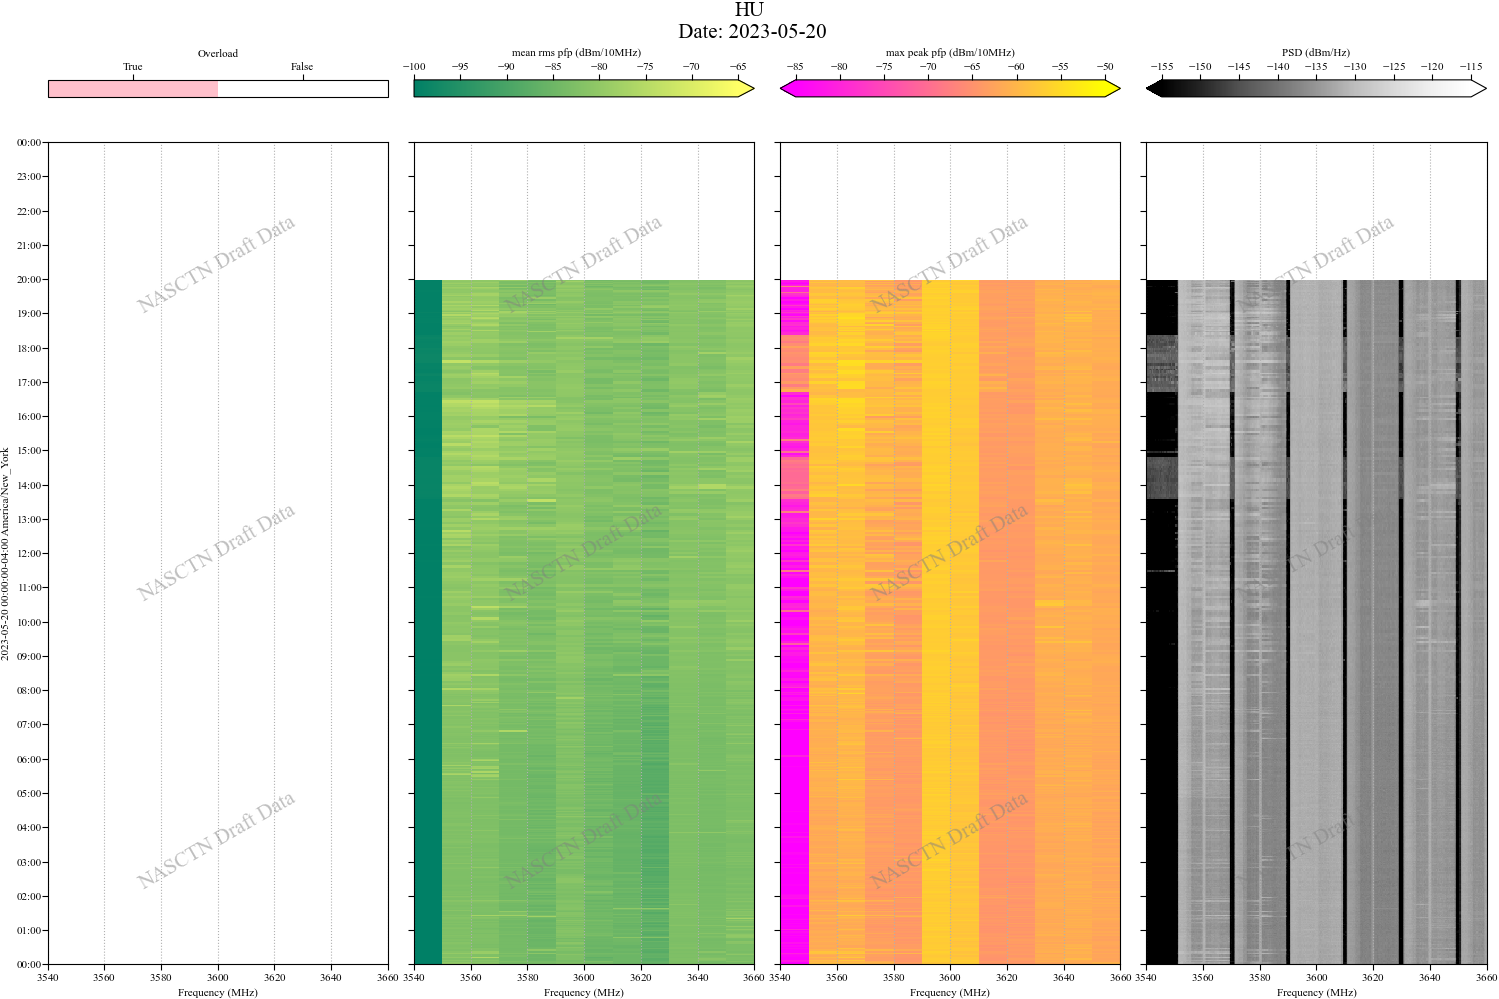

In [14]:
detector_plot(day, "HU", watermark=True)

Missed_coverage=37.83796296296297


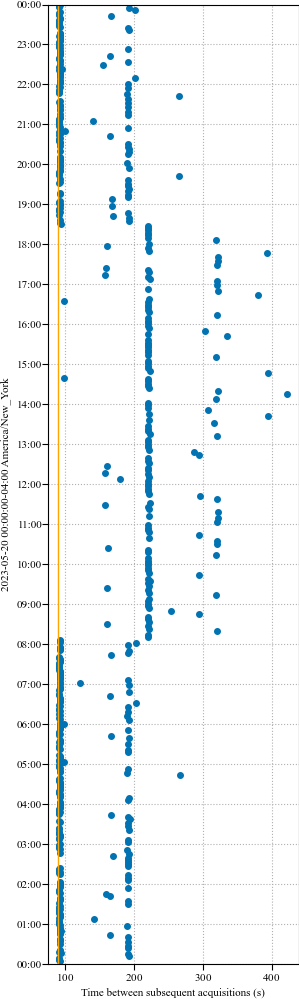

In [147]:
# def day_restarts(day_df,plotit = True):
f0 = day["channel_metadata"].index.get_level_values("frequency").min()
df_inspect = pd.DataFrame(
    day["channel_metadata"].xs(f0, level="frequency").reset_index()["datetime"]
)
df_inspect["num_seconds"] = [t.total_seconds() for t in df_inspect.datetime.diff()]
ideal_num = 24 * 60 * 60 / 92.6
missed = 1 - len(df_inspect) / ideal_num
print(f"Missed_coverage={100*missed}")
tz_info = "America/New_York"
doi_str = df_inspect.datetime.min().date()

plotit = True
if plotit:
    fig, axs = plt.subplots(
        1,
        1,
        sharey=True,
        figsize=(3, 10),
    )
    axs.plot(df_inspect["num_seconds"], df_inspect.datetime, ".")
    axs.axvline(90, color="orange")

    y_start = pd.to_datetime(doi_str).tz_localize(tz_info)
    axs.set_ylim(y_start, y_start + dt.timedelta(hours=24))

    a = axs.get_ylim()
    b = axs.set_yticks(np.linspace(a[0], a[-1], 25))
    axs.yaxis.set_major_formatter(
        mdates.DateFormatter("%H:%M", tz=dtu.tz.gettz(tz_info))
    )
    axs.set_ylabel(f"{y_start} {tz_info}")
    axs.set_xlabel("Time between subsequent acquisitions (s)")

In [ ]:
## Function is superceded by limiter which uses groupby definitions


def limiter0(df, index_key="frequency"):
    freqs = np.unique(df.index.get_level_values(index_key))
    limiter = []
    for f in freqs:
        df_f = df.xs(f, level=index_key)
        limiter += [len(df_f)]
    limit = np.min(limiter)

    df_lim = []
    for f in freqs:
        df_l = df.xs(f, level=index_key, drop_level=False)
        df_l = df_l.iloc[:limit]
        df_lim += [df_l]
    df_lim = pd.concat(df_lim)
    return df_lim